## **0. Tải bộ dữ liệu**
**Lưu ý:** Nếu bạn không thể sử dụng lệnh gdown để tải bộ dữ liệu vì bị giới hạn số lượt tải, hãy tải bộ dữ liệu thử công và upload lên google drive của mình. Sau đó, sử dụng lệnh dưới đây để copy file dữ liệu vào colab:
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1N7rk-kfnDFIGMeX0ROVTjKh71gcgx-7R/view?usp=sharing
!gdown --id 1N7rk-kfnDFIGMeX0ROVTjKh71gcgx-7R

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1N7rk-kfnDFIGMeX0ROVTjKh71gcgx-7R
To: /content/2cls_spam_text_cls.csv
100% 486k/486k [00:00<00:00, 97.6MB/s]


## **1. Import các thư viện cần thiết**

In [2]:
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **2. Đọc bộ dữ liệu**

In [3]:
DATASET_PATH = '/content/2cls_spam_text_cls.csv'
df = pd.read_csv(DATASET_PATH)
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

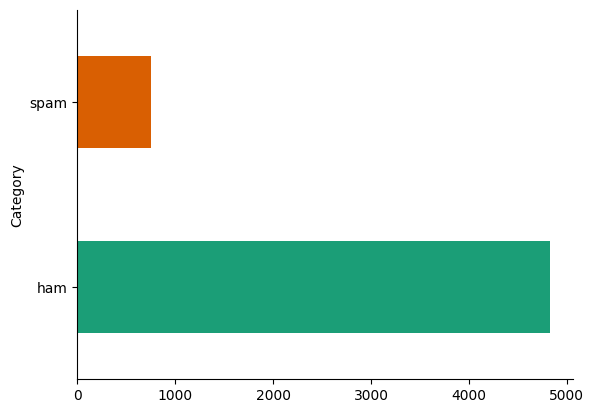

In [15]:
# @title Category

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
print(type(df))
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
(5572, 2)


In [6]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 5572
Number of columns: 2


In [7]:
# đổi từ pandas df sang list
messages = df['Message'].values.tolist()
labels = df['Category'].values.tolist()

In [8]:
print(f'Number of messages: {len(messages)}')
print(f'Number of labels: {len(labels)}')

Number of messages: 5572
Number of labels: 5572


In [9]:
print(f'Number of spam messages: {labels.count("spam")}')
print(f'Number of ham messages: {labels.count("ham")}')

Number of spam messages: 747
Number of ham messages: 4825


In [10]:
print(f'Sample messages: {messages[:5]}')
print(f'Sample labels: {labels[:5]}')

Sample messages: ['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though"]
Sample labels: ['ham', 'ham', 'spam', 'ham', 'ham']


In [11]:
print(type(messages))
print(type(labels))

<class 'list'>
<class 'list'>


## **3. Chuẩn bị bộ dữ liệu**

### **3.1. Xử lý dữ liệu nhãn**

In [16]:
le = LabelEncoder()
y = le.fit_transform(labels)
print(f'Classes: {le.classes_}')
print(f'Encoded labels: {y}')

Classes: ['ham' 'spam']
Encoded labels: [0 0 1 ... 0 0 0]


### **3.2. Xử lý dữ liệu đặc trưng**

In [17]:
def lowercase(text):
    return text.lower()

def punctuation_removal(text):
    translator = str.maketrans('', '', string.punctuation)

    return text.translate(translator)

def tokenize(text):
    return nltk.word_tokenize(text)

def remove_stopwords(tokens):
    stop_words = nltk.corpus.stopwords.words('english')

    return [token for token in tokens if token not in stop_words]

def stemming(tokens):
    stemmer = nltk.PorterStemmer()

    return [stemmer.stem(token) for token in tokens]

def preprocess_text(text):
    text = lowercase(text)
    text = punctuation_removal(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = stemming(tokens)

    return tokens

In [18]:
messages = [preprocess_text(message) for message in messages]

In [19]:
def create_dictionary(messages):
    dictionary = []

    for message in messages:
        for token in message:
            if token not in dictionary:
                dictionary.append(token)

    return dictionary

def create_features(message, dictionary):
    features = np.zeros(len(dictionary))

    for token in message:
        if token in dictionary:
            features[dictionary.index(token)] += 1

    return features

In [20]:
dictionary = create_dictionary(messages)
#for message in messages:
#   print(message)

X = np.array([create_features(message, dictionary) for message in messages])

In [21]:
print(dictionary)
print(X)

['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat', 'ok', 'lar', 'joke', 'wif', 'u', 'oni', 'free', 'entri', '2', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkt', '21st', 'may', '2005', 'text', '87121', 'receiv', 'questionstd', 'txt', 'ratetc', 'appli', '08452810075over18', 'dun', 'say', 'earli', 'hor', 'c', 'alreadi', 'nah', 'dont', 'think', 'goe', 'usf', 'live', 'around', 'though', 'freemsg', 'hey', 'darl', '3', 'week', 'word', 'back', 'id', 'like', 'fun', 'still', 'tb', 'xxx', 'std', 'chg', 'send', '£150', 'rcv', 'even', 'brother', 'speak', 'treat', 'aid', 'patent', 'per', 'request', 'mell', 'oru', 'minnaminungint', 'nurungu', 'vettam', 'set', 'callertun', 'caller', 'press', '9', 'copi', 'friend', 'winner', 'valu', 'network', 'custom', 'select', 'receivea', '£900', 'prize', 'reward', 'claim', 'call', '09061701461', 'code', 'kl341', 'valid', '12', 'hour', 'mobil', '11', 'month', 'r', 'entitl', 'updat', 'late

In [ ]:
len(dictionary)

8166

### **3.3. Chia dữ liệu train/val/test**

In [ ]:
VAL_SIZE = 0.2
TEST_SIZE = 0.125
SEED = 0

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=VAL_SIZE,
                                                  shuffle=True,
                                                  random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size=TEST_SIZE,
                                                    shuffle=True,
                                                    random_state=SEED)

In [ ]:
print(f'Number of training samples: {len(X_train)}')
print(f'Number of validation samples: {len(X_val)}')
print(f'Number of testing samples: {len(X_test)}')

Number of training samples: 3899
Number of validation samples: 1115
Number of testing samples: 558


## **4. Huấn luyện mô hình**

In [ ]:
%%time
model = GaussianNB()
print('Start training...')
model = model.fit(X_train, y_train)
print('Training completed!')

Start training...
Training completed!
CPU times: user 300 ms, sys: 140 ms, total: 440 ms
Wall time: 436 ms


## **5. Đánh giá mô hình**

In [ ]:
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Val accuracy: {val_accuracy}')
print(f'Test accuracy: {test_accuracy}')

Val accuracy: 0.8816143497757848
Test accuracy: 0.8602150537634409


## **6. Thực hiện dự đoán**

In [ ]:
def predict(text, model, dictionary):
    print(text)
    processed_text = preprocess_text(text)
    print(text)
    print(processed_text)

    features = create_features(processed_text, dictionary)
    print(features)
    print(np.array(features).shape)
    features = np.array(features).reshape(1, -1)
    prediction = model.predict(features)
    prediction_cls = le.inverse_transform(prediction)[0]

    return prediction_cls

In [ ]:
test_input = 'I am actually thinking a way of doing something useful'
print(dictionary)
prediction_cls = predict(test_input, model, dictionary)
print(f'Prediction: {prediction_cls}')

['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat', 'ok', 'lar', 'joke', 'wif', 'u', 'oni', 'free', 'entri', '2', 'wkli', 'comp', 'win', 'fa', 'cup', 'final', 'tkt', '21st', 'may', '2005', 'text', '87121', 'receiv', 'questionstd', 'txt', 'ratetc', 'appli', '08452810075over18', 'dun', 'say', 'earli', 'hor', 'c', 'alreadi', 'nah', 'dont', 'think', 'goe', 'usf', 'live', 'around', 'though', 'freemsg', 'hey', 'darl', '3', 'week', 'word', 'back', 'id', 'like', 'fun', 'still', 'tb', 'xxx', 'std', 'chg', 'send', '£150', 'rcv', 'even', 'brother', 'speak', 'treat', 'aid', 'patent', 'per', 'request', 'mell', 'oru', 'minnaminungint', 'nurungu', 'vettam', 'set', 'callertun', 'caller', 'press', '9', 'copi', 'friend', 'winner', 'valu', 'network', 'custom', 'select', 'receivea', '£900', 'prize', 'reward', 'claim', 'call', '09061701461', 'code', 'kl341', 'valid', '12', 'hour', 'mobil', '11', 'month', 'r', 'entitl', 'updat', 'late